**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

**Step 2: Load Dataset and Preprocess**

In [2]:
df = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


**Convert to 3 class classification**

In [5]:
def quality_label(q):
    if q <= 5:
        return 0
    elif q == 6:
        return 1
    else:
        return 2

df["quality_label"] = df["quality"].apply(quality_label)

In [6]:
df["total_acidity"] = df["fixed acidity"] + df["volatile acidity"]
df["density_alcohol"] = df["density"] / df["alcohol"]
df["acid_index"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)
df["sulfur_ratio"] = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["is_high_alcohol"] = (df["alcohol"] > df["alcohol"].median()).astype(int)

**Step 3: Exploratory Data Analysis (EDA)**

**Feature Correlation Heatmap**

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap with Engineered Features")
plt.show()

**Pairplots (Distribution of Quality Labels by Key Features)**

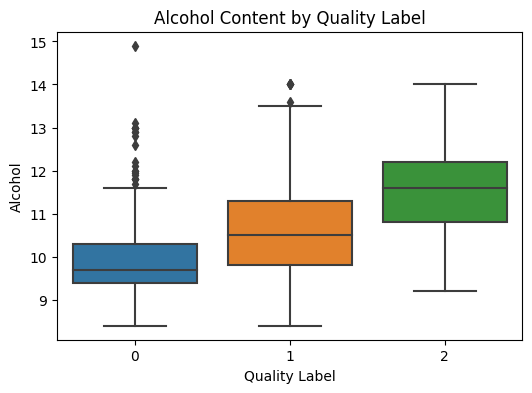

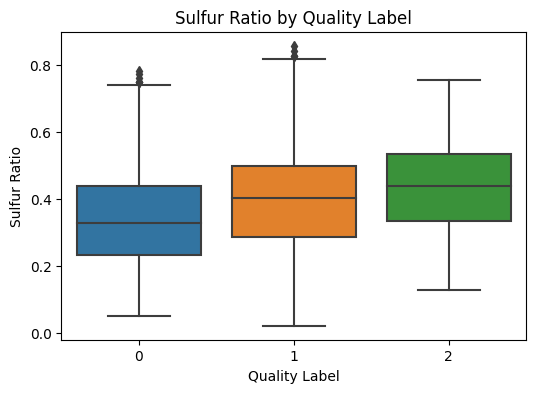

In [8]:
# Alcohol vs Quality
plt.figure(figsize=(6, 4))
sns.boxplot(x="quality_label", y="alcohol", data=df)
plt.title("Alcohol Content by Quality Label")
plt.xlabel("Quality Label")
plt.ylabel("Alcohol")
plt.show()

# Sulfur Ratio vs Quality
plt.figure(figsize=(6, 4))
sns.boxplot(x="quality_label", y="sulfur_ratio", data=df)
plt.title("Sulfur Ratio by Quality Label")
plt.xlabel("Quality Label")
plt.ylabel("Sulfur Ratio")
plt.show()

**Pairplot with Selected Features**

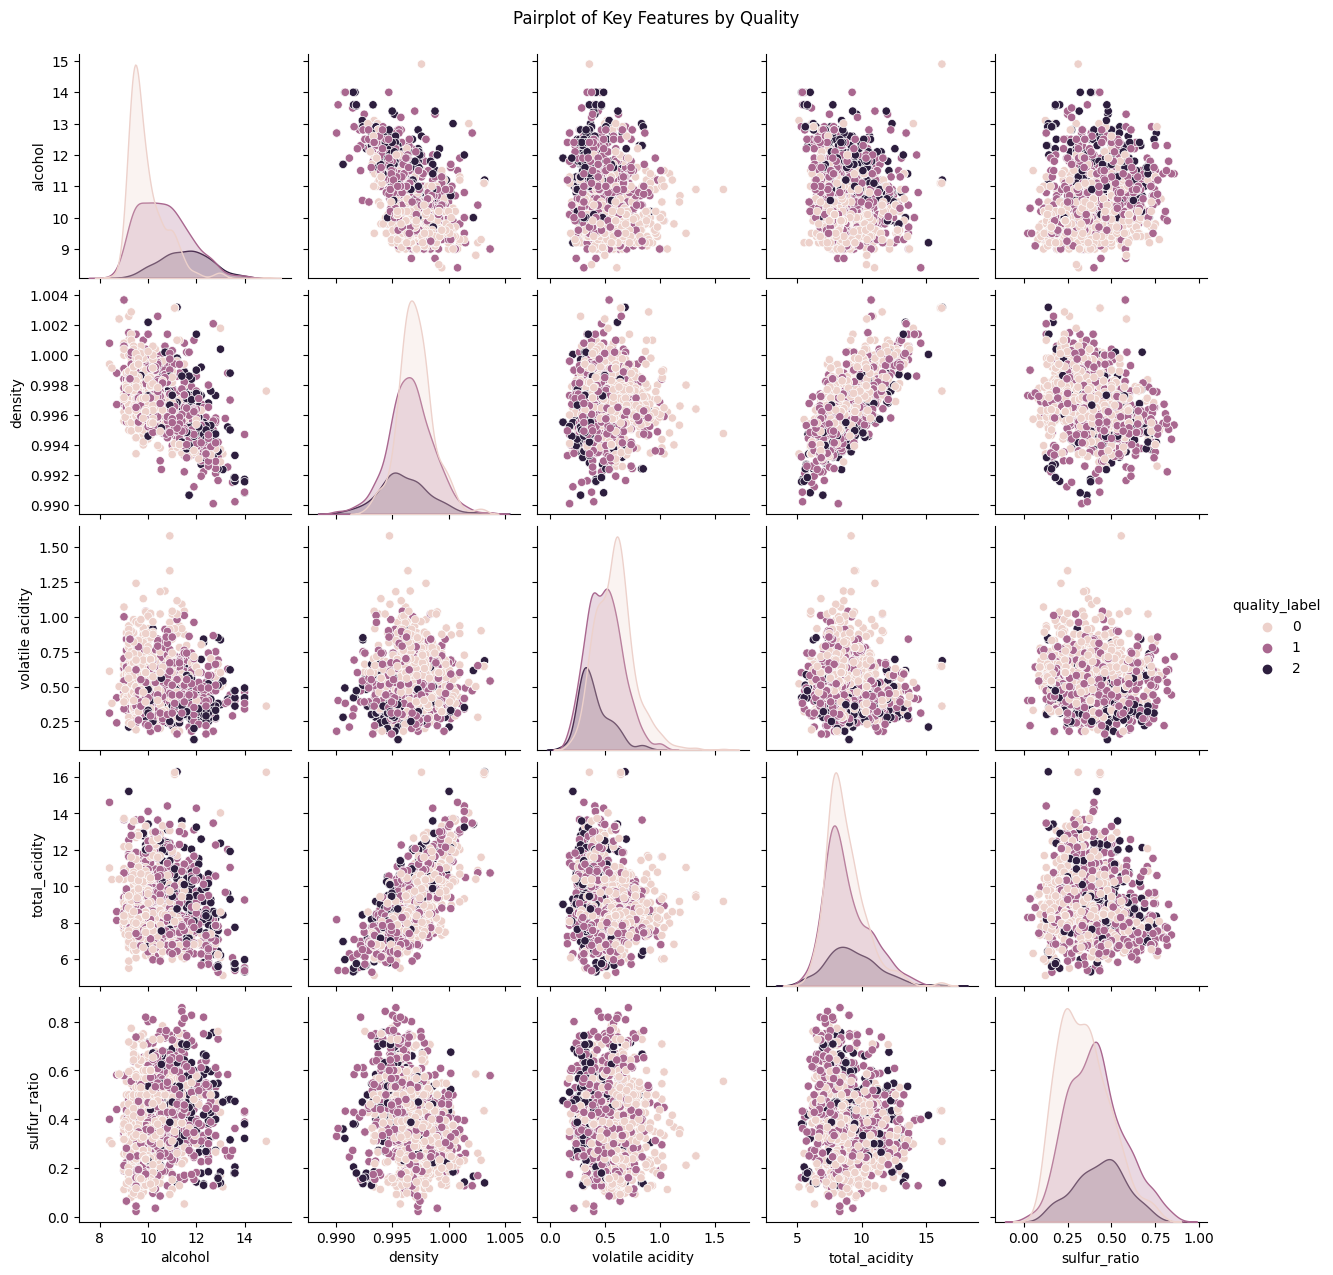

In [9]:
selected_cols = ["alcohol", "density", "volatile acidity", "total_acidity", "sulfur_ratio", "quality_label"]
sns.pairplot(df[selected_cols], hue="quality_label", diag_kind="kde")
plt.suptitle("Pairplot of Key Features by Quality", y=1.02)
plt.show()

**Step 4: Train-test split and Scaling**

In [10]:
X = df.drop(["quality", "quality_label"], axis=1)
y = df["quality_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Advanced Feature Selection**

In [11]:
selector = SelectFromModel(RandomForestClassifier(random_state=42))
selector.fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

**Step 5: Define Models**

In [12]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB()
}

**Train and Evaluation without Tuning**

In [13]:
results_untuned = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test_scaled)
    
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    cm = confusion_matrix(y_test, preds)
    roc_auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]), proba, multi_class='ovr')

    results_untuned[name] = {
        "model": model,
        "accuracy": acc,
        "report": report,
        "conf_matrix": cm,
        "roc_auc": roc_auc,
        "preds": preds,
        "proba": proba
    }
    
best_untuned_name = max(results_untuned, key=lambda k: results_untuned[k]["accuracy"])
best_untuned_model = results_untuned[best_untuned_name]["model"]

In [14]:
print("Untuned Model Accuracies:\n")
for name, result in results_untuned.items():
    print(f"{name:20}: {result['accuracy']:.4f}")

print("\nBest Untuned Model:")
print(f"{best_untuned_name} with Accuracy = {results_untuned[best_untuned_name]['accuracy']:.4f}")

Untuned Model Accuracies:

RandomForest        : 0.7750
GradientBoosting    : 0.7125
SVM                 : 0.6750
LogisticRegression  : 0.6375
KNN                 : 0.6312
NaiveBayes          : 0.6219

Best Untuned Model:
RandomForest with Accuracy = 0.7750


**Confusion Matrix and Classification Report for best untuned model**

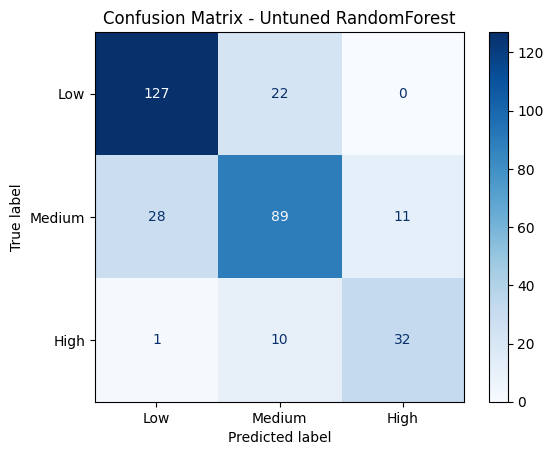

Classification Report for Untuned RandomForest
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       149
           1       0.74      0.70      0.71       128
           2       0.74      0.74      0.74        43

    accuracy                           0.78       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.77      0.78      0.77       320



In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=results_untuned[best_untuned_name]['conf_matrix'], display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Untuned {best_untuned_name}")
plt.show()

print(f"Classification Report for Untuned {best_untuned_name}")
print(classification_report(y_test, results_untuned[best_untuned_name]["preds"]))


**ROC Curves for All untuned models**

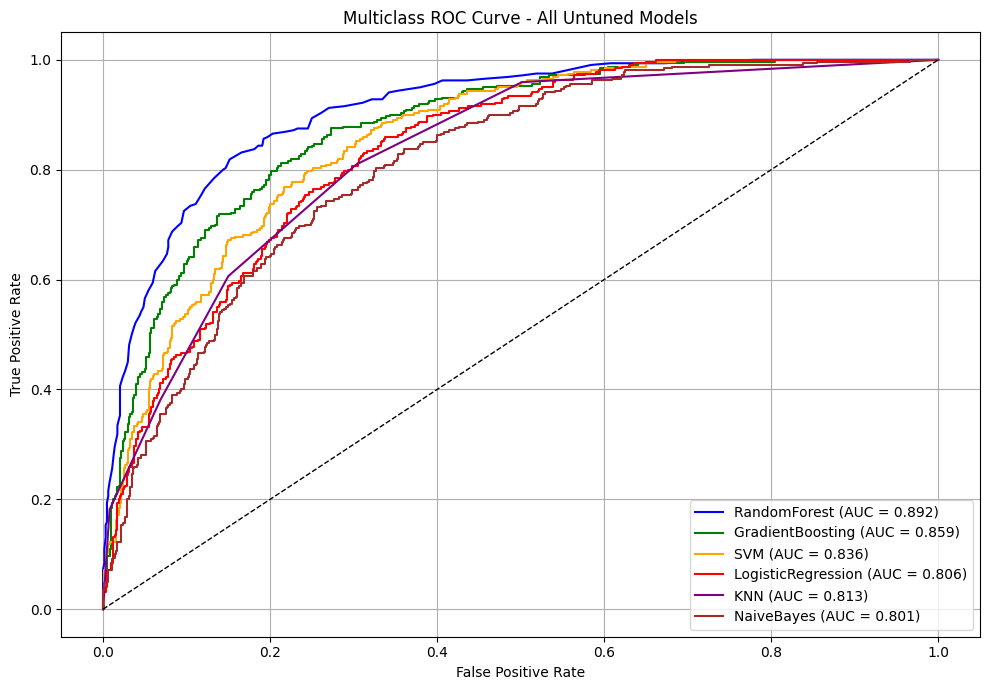

In [16]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

for idx, (name, result) in enumerate(results_untuned.items()):
    y_score = result["proba"]
    
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
    plt.plot(fpr, tpr, color=colors[idx], label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("Multiclass ROC Curve - All Untuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

**Step 6: Define Param Grids**

In [17]:
param_grids = {
    "RandomForest": {"n_estimators": [100, 200], "max_depth": [10, 20, None]},
    "GradientBoosting": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]},
    "SVM": {"C": [1, 10], "kernel": ["rbf", "linear"]},
    "LogisticRegression": {"C": [0.1, 1, 10]},
    "KNN": {"n_neighbors": [3, 5, 7]},
    "NaiveBayes": {}
}

**Train and Evaluation with Tuning**

In [18]:
results_tuned = {}

for name in models.keys():
    if param_grids[name]:
        grid = GridSearchCV(models[name], param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        model = grid.best_estimator_
    else:
        model = models[name].fit(X_train_scaled, y_train)
        
    preds = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test_scaled)
    
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    cm = confusion_matrix(y_test, preds)
    roc_auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]), proba, multi_class='ovr')

    results_tuned[name] = {
        "model": model,
        "accuracy": acc,
        "report": report,
        "conf_matrix": cm,
        "roc_auc": roc_auc,
        "preds": preds,
        "proba": proba
    }

best_tuned_name = max(results_tuned, key=lambda k: results_tuned[k]["accuracy"])
best_tuned_model = results_tuned[best_tuned_name]["model"]

In [19]:
print("Tuned Model Accuracies:\n")
for name, result in results_tuned.items():
    print(f"{name:20}: {result['accuracy']:.4f}")

print("\nBest Tuned Model:")
print(f"{best_tuned_name} with Accuracy = {results_tuned[best_tuned_name]['accuracy']:.4f}")

Tuned Model Accuracies:

RandomForest        : 0.7719
GradientBoosting    : 0.7063
SVM                 : 0.6969
LogisticRegression  : 0.6562
KNN                 : 0.6719
NaiveBayes          : 0.6219

Best Tuned Model:
RandomForest with Accuracy = 0.7719


**Confusion Matrix and Classification Report for best tuned model**

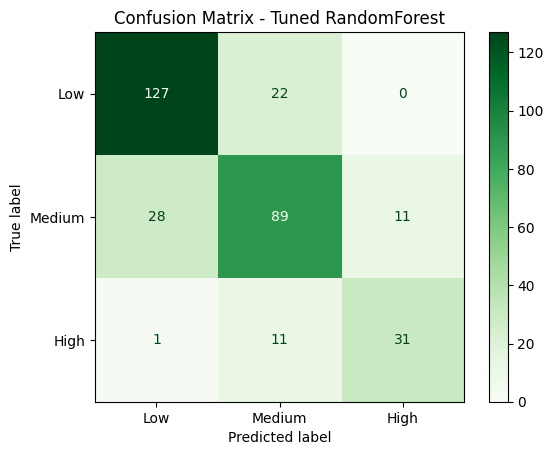

Classification Report for Tuned RandomForest
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       149
           1       0.73      0.70      0.71       128
           2       0.74      0.72      0.73        43

    accuracy                           0.77       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.77      0.77      0.77       320



In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=results_tuned[best_tuned_name]['conf_matrix'], display_labels=["Low", "Medium", "High"])
disp.plot(cmap="Greens")
plt.title(f"Confusion Matrix - Tuned {best_tuned_name}")
plt.show()

print(f"Classification Report for Tuned {best_tuned_name}")
print(classification_report(y_test, results_tuned[best_tuned_name]["preds"]))


**ROC Curves for All tuned models**

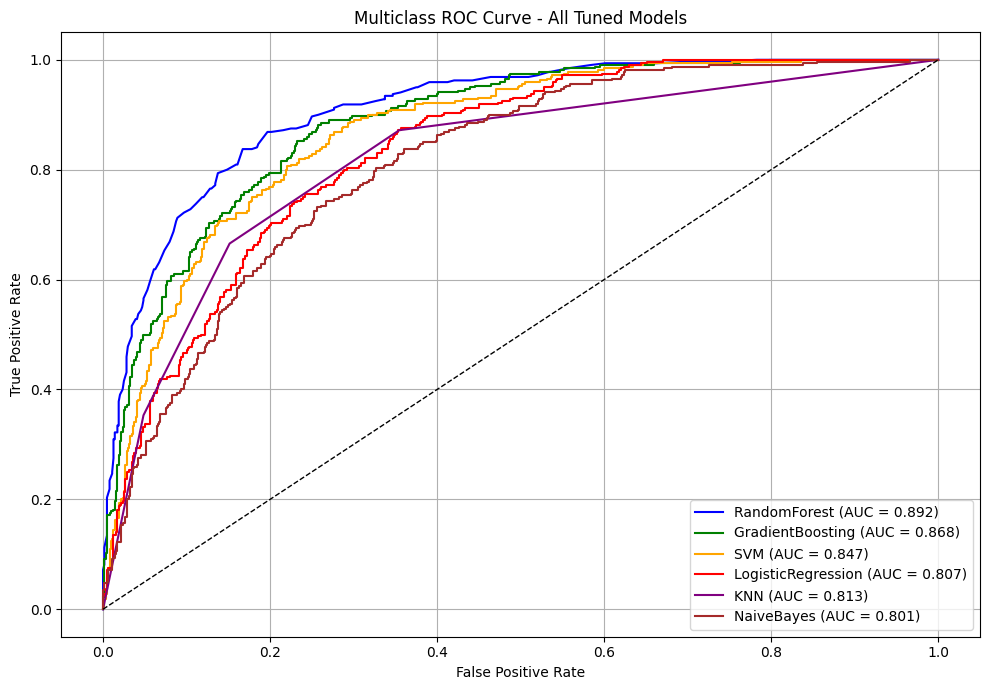

In [21]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

for idx, (name, result) in enumerate(results_tuned.items()):
    y_score = result["proba"]
    
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
    plt.plot(fpr, tpr, color=colors[idx], label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("Multiclass ROC Curve - All Tuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

**Step 7: Accuracy Comparison**

In [22]:
comparison_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy (Untuned)": [results_untuned[m]["accuracy"] for m in models],
    "Accuracy (Tuned)": [results_tuned[m]["accuracy"] for m in models]
})
print(comparison_df)

                Model  Accuracy (Untuned)  Accuracy (Tuned)
0        RandomForest            0.775000          0.771875
1    GradientBoosting            0.712500          0.706250
2                 SVM            0.675000          0.696875
3  LogisticRegression            0.637500          0.656250
4                 KNN            0.631250          0.671875
5          NaiveBayes            0.621875          0.621875


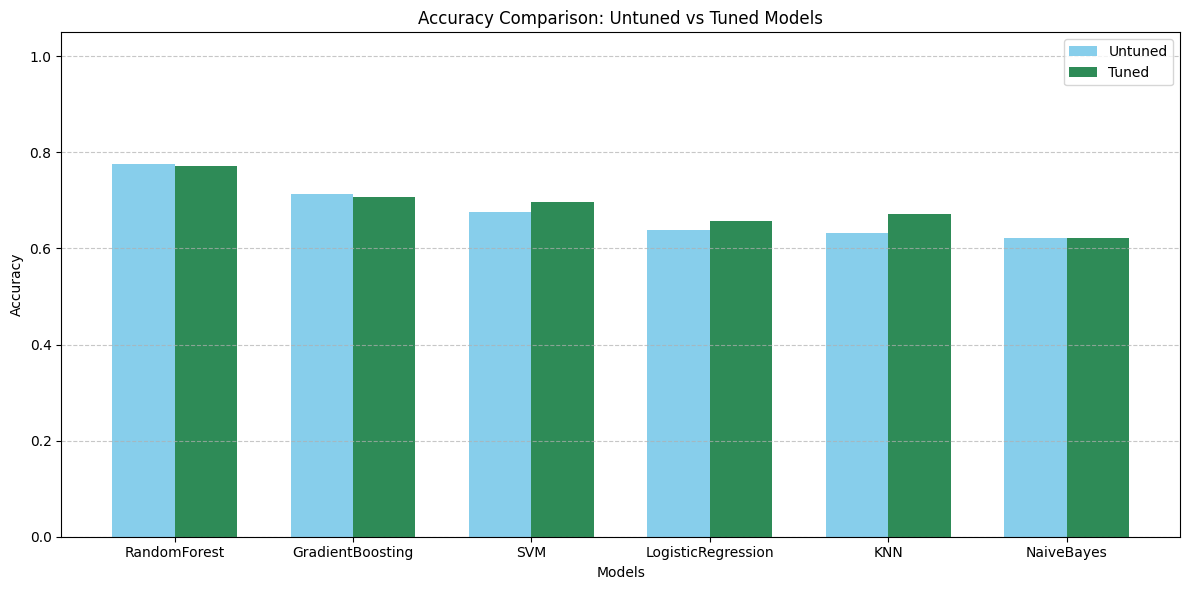

In [23]:
plt.figure(figsize=(12, 6))

x = np.arange(len(comparison_df["Model"]))
width = 0.35

plt.bar(x - width/2, comparison_df["Accuracy (Untuned)"], width, label="Untuned", color="skyblue")
plt.bar(x + width/2, comparison_df["Accuracy (Tuned)"], width, label="Tuned", color="seagreen")

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Untuned vs Tuned Models")
plt.xticks(ticks=x, labels=comparison_df["Model"])
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


**Step 8: Prediction**

In [24]:
sample = X_test.iloc[:10]
true_vals = y_test.iloc[:10]
pred_untuned = best_untuned_model.predict(scaler.transform(sample))
pred_tuned = best_tuned_model.predict(scaler.transform(sample))

final_df = pd.DataFrame({
    "Actual": true_vals.values,
    f"{best_untuned_name} (Untuned)": pred_untuned,
    f"{best_tuned_name} (Tuned)": pred_tuned
})
print(final_df)

   Actual  RandomForest (Untuned)  RandomForest (Tuned)
0       1                       1                     1
1       0                       0                     0
2       0                       0                     0
3       0                       0                     0
4       1                       1                     1
5       1                       2                     2
6       0                       0                     0
7       0                       0                     0
8       1                       1                     1
9       2                       2                     2
